In [1]:
from model import *
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
import cv2
import numpy as np
from scipy.spatial.distance import jaccard
from torch.utils.tensorboard import SummaryWriter
#device = torch.device('cpu')
device = torch.device('cuda:0')

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Dataset Params
paths = ["/data/spacenet/AOI_1_Rio","/data/spacenet/AOI_2_Vegas","/data/spacenet/AOI_3_Paris","/data/crowdai"]
img_dir = "3band"
mask_dir = "masks"
batch_size_tr = 16
batch_size_val = 16
img_size = 256
zero_prop = 1.0 #Drop any images that are more than x percent 0 values.
#Weight map parameters
constant = 200

use_pan = True
#Mixup parameter
lam = 0.05

transform = A.Compose([
            #A.RandomScale(scale_limit=0.25, p=0.10),
            #A.ColorJitter (brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05, always_apply=False, p=0.10),
            A.CropNonEmptyMaskIfExists(width=img_size, height=img_size),
            #A.Flip(p=0.10)
            ])
train = BetaNetDataset(device, paths, img_dir, mask_dir, train_val="train", 
img_size = img_size, use_pan = use_pan, batch_size = batch_size_tr, zero_prop = zero_prop, transform = transform, 
constant=constant, lam=lam)
val = BetaNetDataset(device, paths, img_dir, mask_dir, train_val="val", 
img_size = img_size, use_pan = use_pan, batch_size = batch_size_val, zero_prop = zero_prop, transform = transform,
constant=constant, lam=0)

In [3]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [4]:
x, y = train.gen_batch()

In [1]:
#import torchviz
#y_pred = model(x)
#torchviz.make_dot(y_pred)

In [4]:
model_path = "./model_save/openbldg/model_unetresnet50_ce_1perprop_200tdiv_50perthresh_acc_relu_uniary_grey22 Mar 2023 22:34_4_0.68336"
try:
    best_vloss = float(model_path.split('_')[-1])
    best_vjacc = float(model_path.split('_')[-1])
    model.load_state_dict(torch.load(model_path))
except:
    best_vloss = 1000
    best_vjacc = 0
print(best_vloss)

0.68336


In [5]:
best_vloss = 1000
best_vjacc = 0

In [5]:
from datetime import datetime
writer = SummaryWriter()
timestamp = datetime.now().strftime("%d %b %Y %H:%M")
num_batches_tr = 125
num_batches_val = 125
num_epochs = 20
threshold = 0.5
criterion = OBWeightedBCE(threshold = threshold)

for i in range(1, num_epochs+1):
    running_loss = 0.
    running_jaccard = 0.
    last_loss = 0.
    model.train(True)
    for j in tqdm(range(1, num_batches_tr+1), desc = ("Epoch %d Training" % i)):
        x, y = train.gen_batch()

        optimizer.zero_grad(set_to_none=True)
        
        y_pred = model(x)

        loss = criterion(y_pred, y)

        loss.backward()

        optimizer.step()

        running_loss += loss.detach().item()

        sigmoidOutput = torch.sigmoid(y_pred).detach().cpu().numpy()
        thresholdOutput = (sigmoidOutput > threshold).flatten()
        #reluOutput = F.relu6(y_pred).detach().cpu().numpy()
        #thresholdOutput = (reluOutput > threshold).flatten()
        
        true = y[:,1,0,:,:].cpu().numpy().flatten()
        running_jaccard += (1-jaccard(thresholdOutput, true))

        del x
        del y
        del y_pred
        del loss
        torch.cuda.empty_cache()

    avg_loss_tr = running_loss / num_batches_tr
    avg_jaccard_tr = running_jaccard / num_batches_tr
    running_loss = 0.
    running_jaccard = 0.

    model.train(False)
    for k in tqdm(range(1, num_batches_val+1), desc = ("Epoch %d Validation" % i)):
        x, y = val.gen_batch()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        running_loss += loss.detach().item()

        sigmoidOutput = torch.sigmoid(y_pred).detach().cpu().numpy()
        thresholdOutput = (sigmoidOutput > threshold).flatten()

        #reluOutput = F.relu6(y_pred).detach().cpu().numpy()
        #thresholdOutput = (reluOutput > threshold).flatten()

        true = y[:,1,0,:,:].cpu().numpy().flatten()
        running_jaccard += (1-jaccard(thresholdOutput, true))
        
        del x
        del y
        del y_pred
        del loss
        torch.cuda.empty_cache()

    avg_loss_val = running_loss / num_batches_val
    avg_jaccard_val = running_jaccard / num_batches_val
    scheduler.step(avg_loss_val)
    
    print('Learning Rate: ', optimizer.param_groups[0]["lr"])

    print('LOSS train {} valid {}'.format(avg_loss_tr, avg_loss_val))
    print('ACC train {} valid {}'.format(avg_jaccard_tr, avg_jaccard_val))

    writer.add_scalar('Loss/train', avg_loss_tr, i)
    writer.add_scalar('Loss/val', avg_loss_val, i)
    writer.add_scalar('Jaccard/train', avg_jaccard_tr, i)
    writer.add_scalar('Jaccard/val', avg_jaccard_val, i)

    #if avg_loss_val <= best_vloss:
    #    best_vloss = avg_loss_val
    #    model_path = 'model_save/openbldg/model_unetresnet50_ce_1perprop_200tdiv_75perthresh_uniary{}_{}_{}'.format(timestamp, i, round(avg_loss_val, 5))
    #    torch.save(model.state_dict(), model_path)

    if avg_jaccard_val >= best_vjacc:
        best_vjacc = avg_jaccard_val
        model_path = 'model_save/openbldg/model_unetresnet50_ce_1perprop_200tdiv_50perthresh_acc_sig_uniary_grey{}_{}_{}'.format(timestamp, i, round(avg_jaccard_val, 5))
        torch.save(model.state_dict(), model_path)
    

Epoch 1 Validation: 100%|██████████| 125/125 [01:25<00:00,  1.46it/s]


Learning Rate:  0.01
LOSS train 0.19871364307403563 valid 0.19809892594814302
ACC train 0.7395879756996132 valid 0.6797795535928438


Epoch 2 Validation: 100%|██████████| 125/125 [01:25<00:00,  1.46it/s]


Learning Rate:  0.01
LOSS train 0.19395311295986176 valid 0.21111687803268434
ACC train 0.7514183099244962 valid 0.6737936642221753


Epoch 3 Validation: 100%|██████████| 125/125 [01:28<00:00,  1.42it/s]


Learning Rate:  0.01
LOSS train 0.1930623425245285 valid 0.1938655876517296
ACC train 0.7484468850055219 valid 0.6868224472262456


Epoch 4 Validation: 100%|██████████| 125/125 [01:25<00:00,  1.45it/s]


Learning Rate:  0.01
LOSS train 0.18433313727378844 valid 0.19753750908374787
ACC train 0.7576962021986137 valid 0.6955838018597895


Epoch 5 Validation: 100%|██████████| 125/125 [01:25<00:00,  1.47it/s]


Learning Rate:  0.01
LOSS train 0.18397810244560242 valid 0.21463091856241226
ACC train 0.7628752414696289 valid 0.680864445882531


Epoch 6 Validation: 100%|██████████| 125/125 [01:26<00:00,  1.44it/s]


Learning Rate:  0.01
LOSS train 0.17953747236728668 valid 0.20833877003192902
ACC train 0.7667292658472027 valid 0.683444556802508


Epoch 7 Validation: 100%|██████████| 125/125 [01:24<00:00,  1.47it/s]


Learning Rate:  0.01
LOSS train 0.18265904319286347 valid 0.18330659931898116
ACC train 0.7671109796350293 valid 0.7038122836314358


Epoch 8 Validation: 100%|██████████| 125/125 [01:23<00:00,  1.50it/s]


Learning Rate:  0.01
LOSS train 0.181009948015213 valid 0.1806932637691498
ACC train 0.7747944910121393 valid 0.7066888644018465


Epoch 9 Validation: 100%|██████████| 125/125 [01:25<00:00,  1.46it/s]


Learning Rate:  0.01
LOSS train 0.173157209277153 valid 0.1997237383723259
ACC train 0.7789510184773322 valid 0.6912922954403337


Epoch 10 Validation: 100%|██████████| 125/125 [01:23<00:00,  1.49it/s]


Learning Rate:  0.01
LOSS train 0.17147352862358092 valid 0.19095581078529358
ACC train 0.7839458226105777 valid 0.7028245237396088


Epoch 11 Validation: 100%|██████████| 125/125 [01:23<00:00,  1.50it/s]


Learning Rate:  0.01
LOSS train 0.17046704638004304 valid 0.18554775309562682
ACC train 0.780217305893594 valid 0.7087823805543697


Epoch 12 Validation: 100%|██████████| 125/125 [01:24<00:00,  1.49it/s]


Learning Rate:  0.01
LOSS train 0.17073315179347992 valid 0.20046810883283614
ACC train 0.7834240703956896 valid 0.6987418503155487


Epoch 13 Validation: 100%|██████████| 125/125 [01:23<00:00,  1.49it/s]


Learning Rate:  0.01
LOSS train 0.16966880357265474 valid 0.1754152865409851
ACC train 0.7843482492845484 valid 0.7148278898857789


Epoch 14 Validation: 100%|██████████| 125/125 [01:25<00:00,  1.46it/s]


Learning Rate:  0.01
LOSS train 0.17161029958724974 valid 0.18221329951286316
ACC train 0.7790263317604205 valid 0.7131650417210202


Epoch 15 Validation: 100%|██████████| 125/125 [01:24<00:00,  1.48it/s]


Learning Rate:  0.01
LOSS train 0.16117482662200927 valid 0.16922997307777404
ACC train 0.7927451112368505 valid 0.7144812771725569


Epoch 16 Validation: 100%|██████████| 125/125 [01:24<00:00,  1.47it/s]


Learning Rate:  0.01
LOSS train 0.1675035368204117 valid 0.16688145804405213
ACC train 0.7916791802915214 valid 0.7174091866118548


Epoch 17 Validation: 100%|██████████| 125/125 [01:24<00:00,  1.48it/s]


Learning Rate:  0.01
LOSS train 0.16411424332857133 valid 0.16902850598096847
ACC train 0.7928518807217769 valid 0.7122886549182302


Epoch 18 Training:  82%|████████▏ | 102/125 [04:33<01:01,  2.68s/it]


KeyboardInterrupt: 

Jaccard:  0.6096511470069228


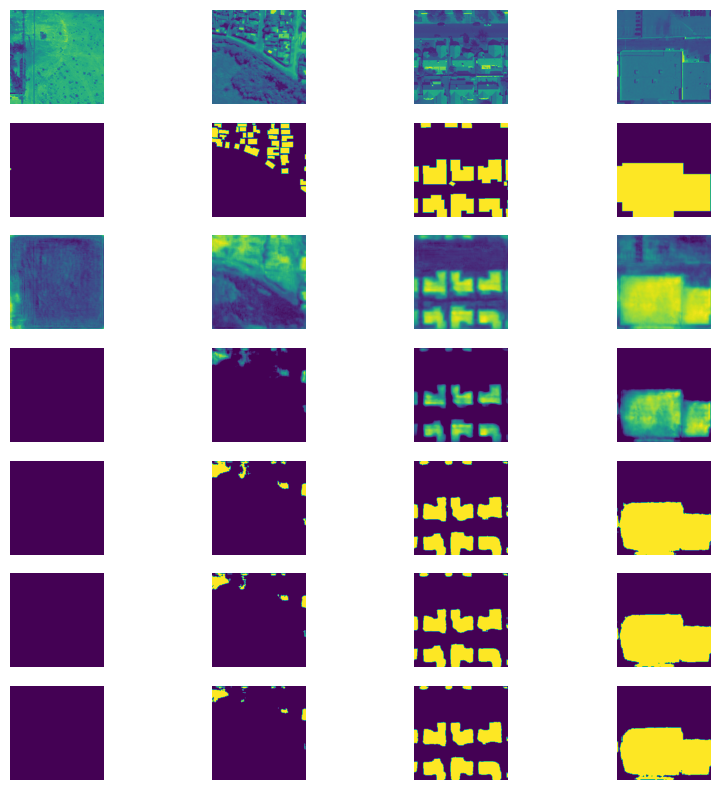

In [6]:
import numpy as np

#model.load_state_dict(torch.load("./model_save/openbldg/model_unetresnet50_ce_1perprop_200tdiv_50perthresh_acc_relu_uniary16 Mar 2023 20:31_7_0.69162"))
x, y = val.gen_batch()
model.train(False)
y_pred = model(x)
y_pred_g = y_pred.detach().cpu().numpy()

y_pred_sig = F.relu(y_pred)

y_pred_sig_g = y_pred_sig.detach().cpu().numpy()

y_pred_thresh_hi = (y_pred_sig > 0.80)
y_pred_thresh_hi_g = y_pred_thresh_hi.cpu().numpy()

y_pred_thresh_med = (y_pred_sig > 0.65)
y_pred_thresh_med_g = y_pred_thresh_med.cpu().numpy()

y_pred_thresh_lo = (y_pred_sig > 0.5)
y_pred_thresh_lo_g = y_pred_thresh_lo.cpu().numpy()

print('Jaccard: ', 1 - jaccard(y[:,1,0,:,:].cpu().numpy().flatten(), y_pred_thresh_lo_g.flatten()))

fig, axs = plt.subplots(7, 4, figsize=[10,10])
axs[0,0].imshow(x[0,:,:,:].cpu().numpy().transpose((1,2,0)))
axs[0,1].imshow(x[1,:,:,:].cpu().numpy().transpose((1,2,0)))
axs[0,2].imshow(x[2,:,:,:].cpu().numpy().transpose((1,2,0)))
axs[0,3].imshow(x[3,:,:,:].cpu().numpy().transpose((1,2,0)))
axs[1,0].imshow(y.cpu().numpy()[0,1,0,:,:])
axs[1,1].imshow(y.cpu().numpy()[1,1,0,:,:])
axs[1,2].imshow(y.cpu().numpy()[2,1,0,:,:])
axs[1,3].imshow(y.cpu().numpy()[3,1,0,:,:])
axs[2,0].imshow(y_pred_g[0,0,:,:])
axs[2,1].imshow(y_pred_g[1,0,:,:])
axs[2,2].imshow(y_pred_g[2,0,:,:])
axs[2,3].imshow(y_pred_g[3,0,:,:])
axs[3,0].imshow(y_pred_sig_g[0,0,:,:])
axs[3,1].imshow(y_pred_sig_g[1,0,:,:])
axs[3,2].imshow(y_pred_sig_g[2,0,:,:])
axs[3,3].imshow(y_pred_sig_g[3,0,:,:])
axs[4,0].imshow(y_pred_thresh_lo_g[0,:,:].squeeze(0))
axs[4,1].imshow(y_pred_thresh_lo_g[1,:,:].squeeze(0))
axs[4,2].imshow(y_pred_thresh_lo_g[2,:,:].squeeze(0))
axs[4,3].imshow(y_pred_thresh_lo_g[3,:,:].squeeze(0))
axs[5,0].imshow(y_pred_thresh_med_g[0,:,:].squeeze(0))
axs[5,1].imshow(y_pred_thresh_med_g[1,:,:].squeeze(0))
axs[5,2].imshow(y_pred_thresh_med_g[2,:,:].squeeze(0))
axs[5,3].imshow(y_pred_thresh_med_g[3,:,:].squeeze(0))
axs[6,0].imshow(y_pred_thresh_hi_g[0,:,:].squeeze(0))
axs[6,1].imshow(y_pred_thresh_hi_g[1,:,:].squeeze(0))
axs[6,2].imshow(y_pred_thresh_hi_g[2,:,:].squeeze(0))
axs[6,3].imshow(y_pred_thresh_hi_g[3,:,:].squeeze(0))

for i in range(0,4):
    for j in range(0, 7):
        axs[j, i].axis('off')


del x
del y
del y_pred
del y_pred_g
del y_pred_sig
del y_pred_sig_g
del y_pred_thresh_lo
del y_pred_thresh_lo_g
del y_pred_thresh_med
del y_pred_thresh_med_g
del y_pred_thresh_hi
del y_pred_thresh_hi_g
torch.cuda.empty_cache()


In [20]:
#test_x, test_y = load_testset(json_path='./test_set.json', device=torch.device('cpu'), img_size=256, transform=transform, mask_dir="masks", img_dir="3band")

jaccard_list = []
step = 10
for i in range(0, test_x.shape[0], step):
    x = test_x[i:i+step,:,:,:].to(device)
    y = test_y[i:i+step,:,:,:].cpu().numpy().flatten()
    pred = model(x)
    pred_sig = torch.relu(pred).detach().cpu().numpy()
    pred_thresh = (pred_sig > 0.95).flatten()

    jaccard_list.append(1 - jaccard(y, pred_thresh))

print('Jaccard: ', np.asarray(jaccard_list).mean())


Jaccard:  0.6223335402542436


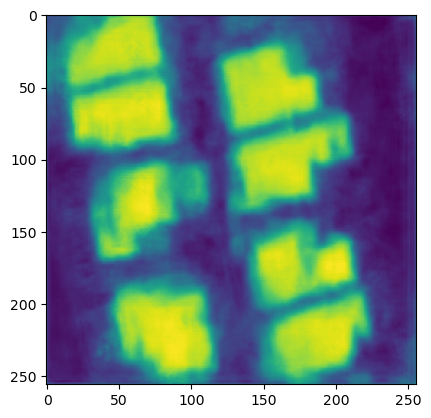

In [19]:
plt.imshow(pred[2,0,:,:].detach().cpu().numpy())